# Доверительные интервалы для двух долей
Точнее: для разности двух долей

In [2]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats import weightstats
from statsmodels.stats.proportion import proportion_confint

## Загрузка данных
Есть товар или услуга, которую хотим рекламировать. Есть старый баннер и новый. Хотим проверить, какой из них лучше.   
Собрали выборку.

In [3]:
data_path = './data/banner_click_stat.txt'

In [4]:
data = pd.read_csv(data_path, header=None, sep='\t')

In [5]:
data.columns = ['banner_a', 'banner_b']

In [6]:
data.head(2)

,banner_a,banner_b
0,0,0
1,1,1


In [7]:
data.describe()

,banner_a,banner_b
count,1000.000000,1000.000000
mean,0.037000,0.053000
std,0.188856,0.224146
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


## Интервальные оценки долей
Используем метод Уилсона, так как доля успехов относительно небольшая.

In [8]:
conf_int_banner_a = proportion_confint(count=data['banner_a'].sum(),
                                       nobs=data.shape[0], # использовать кол-во не нулл значений?
                                       method='wilson')
conf_int_banner_b = proportion_confint(count=data['banner_b'].sum(),
                                       nobs=data.shape[0],
                                       method='wilson')

In [31]:
print(f"Interval for banner A [{conf_int_banner_a[0]:.5f}, {conf_int_banner_a[1]:.5f}], width = {conf_int_banner_a[1] - conf_int_banner_a[0]:.5f}")
print(f"Interval for banner B [{conf_int_banner_b[0]:.5f}, {conf_int_banner_b[1]:.5f}], width = {conf_int_banner_b[1] - conf_int_banner_b[0]:.5f}")


Interval for banner A [0.02696, 0.05058], width = 0.02362
Interval for banner B [0.04075, 0.06867], width = 0.02793


### Как их сравнить?
Интервалы пересекаются, поэтому построим интервал для разности.

## Доверительный интервал для разности долей (независимые выборки)
Посчитаем для каждой выборки сколько было кликов и не-кликов, на основе этого рассчитаем статистики p1 и p2.
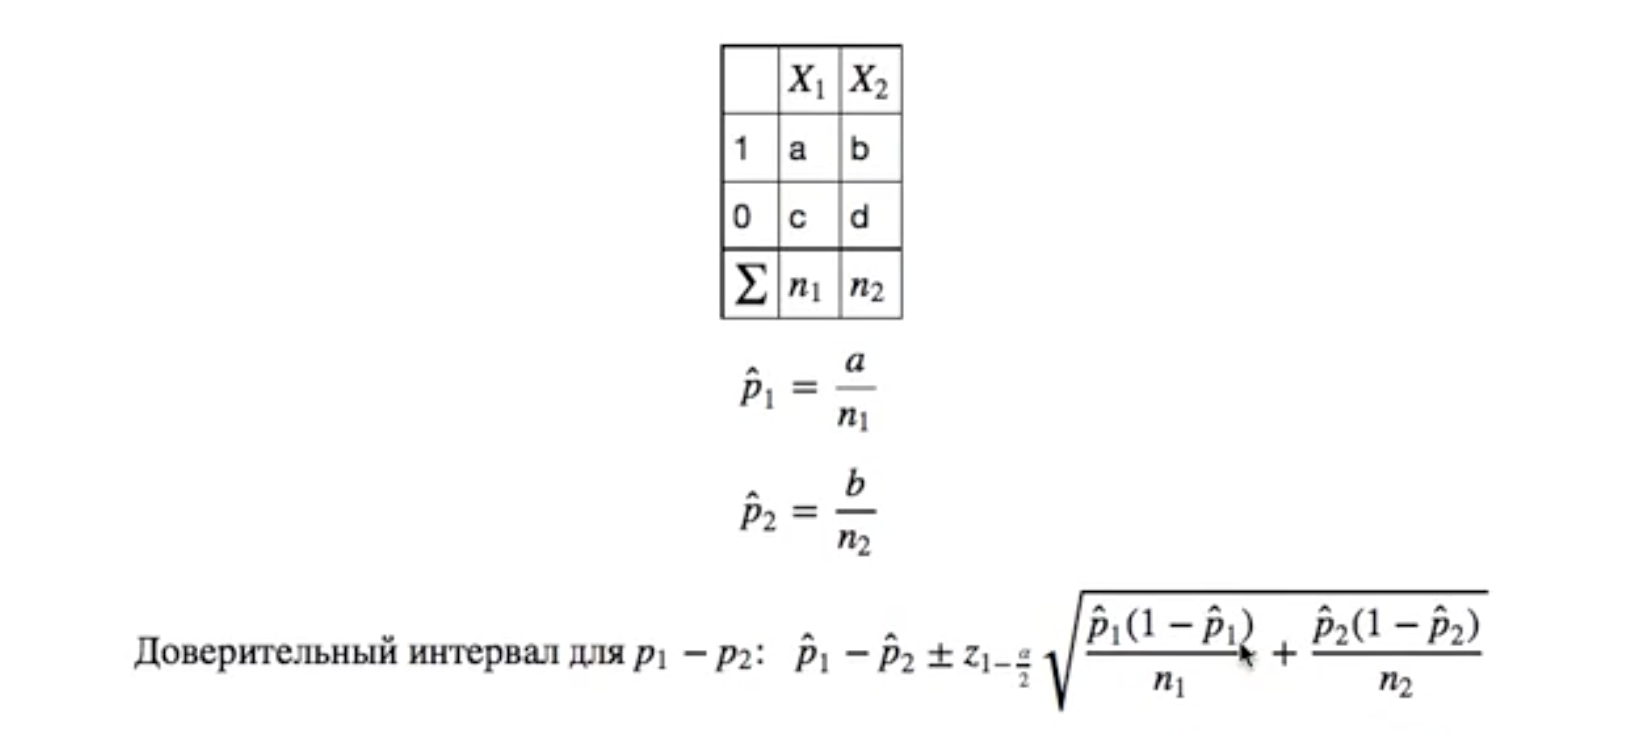

In [25]:
def proportion_confint_diff_ind(sample1, sample2, alpha=0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2)
    n1 = len(sample1)
    n2 = len(sample2)
    p1 = sum(sample1) / n1
    p2 = sum(sample2) / n2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    
    return left_boundary, right_boundary

In [26]:
conf_int = proportion_confint_diff_ind(data['banner_a'], data['banner_b'])

In [30]:
print(f"Interval: [{conf_int[0]:.5f}, {conf_int[1]:.5f}], width = {conf_int[1] - conf_int[0]:.5f}")

Interval: [-0.03416, 0.00216], width = 0.03631


Интервал смещен левее нуля. Но ноль входит в интервал. И пока еще не совсем понятно, есть ли значимые различия.

### Доверительный интервал для разности долей (связанные выборки)
Предположим, что мы показывали баннер одним и тем же людям, то есть одни и те же люди оценивали как баннер A, старый баннер, так и баннер B. В этом случае мы с вами можем сказать, что речь идет уже о связанных выборках, они уже не являются независимыми.    
Для того, чтобы такую оценку получить, сначала нам нужно выписать таблицу сопряженности.
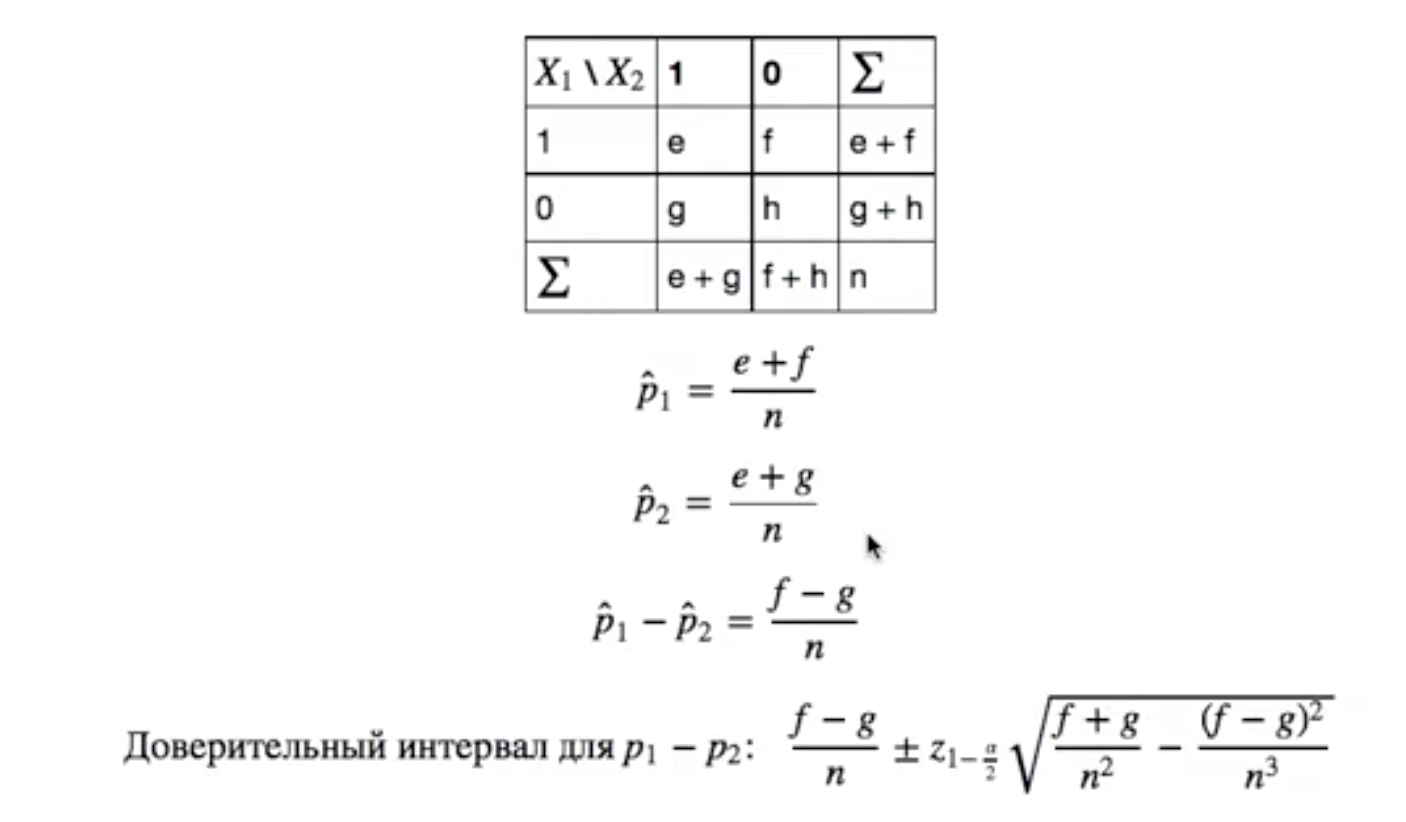

In [39]:
def proportions_confint_diff_re(sample1, sample2, alpha=0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2)
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n - z * np.sqrt((f + g) / n ** 2 - (f - g) ** 2 / n ** 3)
    rigth_boundary = float(f - g) / n + z * np.sqrt((f + g) / n ** 2 - (f - g) ** 2 / n ** 3)
    
    return left_boundary, rigth_boundary

In [41]:
conf_int_re = proportions_confint_diff_re(data['banner_a'], data['banner_b'])

In [42]:
print(f"Interval: [{conf_int_re[0]:.5f}, {conf_int_re[1]:.5f}], width = {conf_int_re[1] - conf_int_re[0]:.5f}")

Interval: [-0.02669, -0.00531], width = 0.02138


Весь интервал лежит левее нуля. Это значит, что новый баннер лучше старого.

#### Вопросы, которые возникли по ходу выполнения работы
1. Что лежит под капотом у proportion_confint?
2. Почему именно разность надо сравнить? Можно ли делать еще как-нибудь?
3. Почему на этом примере перешли от независимых выборок к зависимым? И типа выбрали метод, который больше подошел к "правильному" выводу, которому мы хотели прийти изначально.